# LSTM Autoencoder

- 정상적인 데이터로 모델 학습 후 비정상적인 데이터를 넣어 디코딩하게 되면 정상 데이터 특성과 디코딩 된 데이터 간의 차이인 재구성 손실(Reconstruction Error)를 계산하여 손실이 낮은 부분은 normal, 높은 부분은 abnormal로 판단
- Sequence data에 Encoder-Decoder LSTM Architecture를 적용하여 구현. Model에 input sequence가 순차적으로 들어오게 되고, 마지막 input sequence가 들어온 후 decoder는 input sequence를 재생성하거나 목표 sequence에 대한 예측을 출력.
- LSTM Autoencoder 학습 시 normal data로만 학습.

## LSTM Autoencoder through Curve shifting

Curve Shifting을 통해 데이터의 시점을 변환해주고 normal 데이터만을 통해 LSTM AE모델을 학습. 그 후 재구성 손실을 계산 후 Precision Recall Curve를 통해 normal/abnormal을 구분하기 위한 threshold를 지정하고 이를 기준으로 test set의 재구성 손실을 분류하여 t+n 시점을 예측.

### 1. Curve Shifting

사전 예측 개념을 적용하기 위한 Shifting 방법. 비정상 신호를 n일 전에 조기예측 하고자 한다면 n일 만큼 shift하는게 아니라 비정상 신호가 있는 날짜로부터 n일 전까지의 데이터를 비정상 신호로 바꾸어 주는것.
그후 본래 비정상 신호 데이터를 제거해주는데 라벨을 바꿔주는 순간 비정상 신호 예측 문제가 아닌 비정상 신호 조짐 예측 문제가 되는것이기 때문에 데이터의 학습혼동을 없애주기 위해 제거.

### 2. Threshold by Precision-Recall-Curve

적절한 Threshold값을 적용하기 위한 방법.
Recall과 Precision이 서로 Trade off 관계를 가지기 때문에 어느 한쪽에 치우치지 않는 최적의 threshold를 구하기 위한 방법.

## Implementation

### Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorboard
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Dataset

In [5]:
LABELS = ['Normal', 'Break']

In [6]:
df = pd.read_excel('./processminer-rare-event-mts.xlsx', engine='openpyxl')

In [7]:
df.shape

(18398, 63)

In [8]:
Counter(df['y'])

Counter({0: 18274, 1: 124})

### Curve Shifting

In [9]:
sign = lambda x: (1, -1)[x < 0]
def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for _ in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    
    # Remove the rows with labelcol == 1
    df = df.drop(df[df[labelcol]==1].index)
    
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    
    df.loc[df[labelcol] > 0, labelcol] = 1
    
    return df

In [10]:
shifted_df = curve_shift(df, shift_by=-5)
shifted_df.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,1999-05-01 00:00:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,1999-05-01 00:02:00,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,1999-05-01 00:04:00,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,1999-05-01 00:06:00,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,1999-05-01 00:08:00,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [11]:
shifted_df = shifted_df.drop(['time', 'x28','x61'], axis=1)

In [12]:
input_x = shifted_df.drop('y', axis=1).values
input_y = shifted_df['y'].values
n_features = input_x.shape[1]

In [13]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps -1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+timesteps+1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [14]:
timesteps = 5

In [15]:
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape)

(18268, 5, 59)


### Trian Test Split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)

print(len(x_train))
print(len(x_valid))
print(len(x_test))

11691
2923
3654


Normal(0) / Break(1) data split

In [17]:
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

### Standardize

In [18]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [19]:
scaler = StandardScaler().fit(flatten(x_train_y0))

x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

### Model

In [20]:
epochs = 200
batch = 128
lr = 0.001

In [21]:
inputs = Input(shape=(timesteps, n_features))
# Encoder
x = LSTM(32, activation='relu', return_sequences=True)(inputs)
x = LSTM(16, activation='relu', return_sequences=False)(x)
x = RepeatVector(timesteps)(x)

# Decoder
x = LSTM(16, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu', return_sequences=True)(x)
x = TimeDistributed(Dense(n_features))(x)

model = Model(inputs, x)

In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 59)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 32)             11776     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 59)            

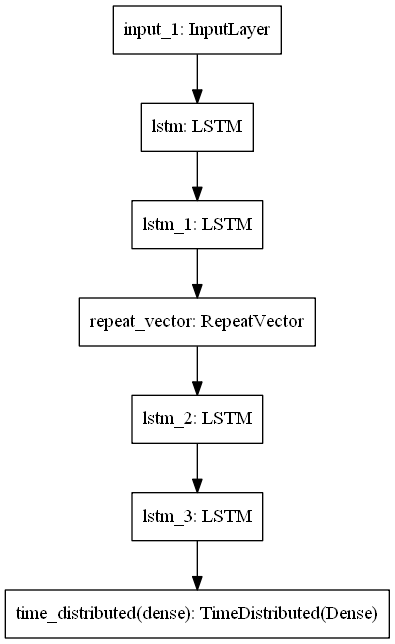

In [23]:
plot_model(model)

In [24]:
model.compile(loss='mse', optimizer = Adam(lr))

In [25]:
logdir = 'log/LSTMAE/'+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [27]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [28]:
history = model.fit(x_train_y0_scaled, x_train_y0_scaled,
                   epochs = epochs, batch_size = batch,
                   validation_data=(x_valid_y0_scaled, x_valid_y0_scaled), callbacks=[tensorboard_callback, es])

Epoch 1/200
 1/89 [..............................] - ETA: 0s - loss: 0.9847WARNING:tensorflow:From c:\users\ilvna\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
89/89 [==============================] - 3s 36ms/step - loss: 0.8543 - val_loss: 0.6105
Epoch 2/200
89/89 [==============================] - 3s 30ms/step - loss: 0.5014 - val_loss: 0.4267
Epoch 3/200
89/89 [==============================] - 3s 30ms/step - loss: 0.3784 - val_loss: 0.3394
Epoch 4/200
89/89 [==============================] - 3s 30ms/step - loss: 0.3180 - val_loss: 0.2943
Epoch 5/200
89/89 [==============================] - 3s 30ms/step - loss: 0.2820 - val_loss: 0.2678
Epoch 6/200
89/89 [==============================] - 3s 30ms/step - loss: 0.2601 - val_loss: 0.2504
Epoch 7/200
89/89 [==============================]

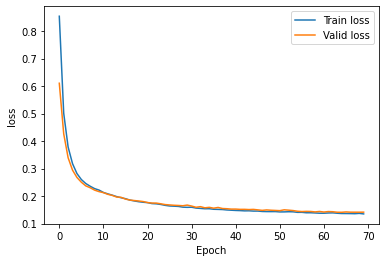

In [29]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

### Threshold by Precision Recall Curve

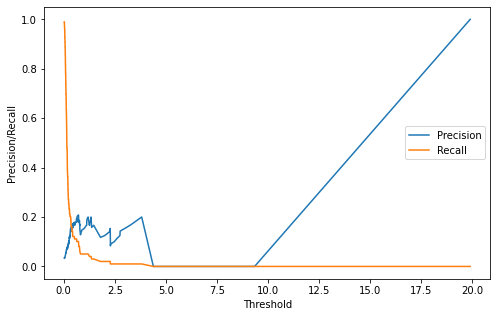

In [30]:
valid_x_predictions = model.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions),
                      2,), axis=1)

error_df = pd.DataFrame({'Reconstruction_error' : mse,
                        'True_class' : list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [31]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('Precision: ',precision_rt[index_cnt],', Recall: ', recall_rt[index_cnt])

threshold_fixed = threshold_rt[index_cnt]
print('Threshold: ', threshold_fixed)

Precision:  0.16161616161616163 , Recall:  0.16161616161616163
Threshold:  0.3980707612878629


Best threshold : 0.403

### Predict Test

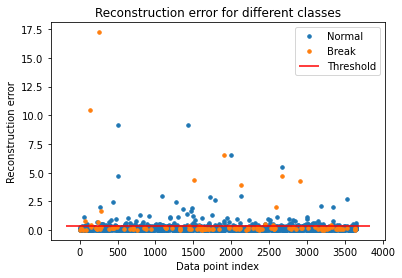

In [32]:
test_x_predictions = model.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class' : y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### Confusion Matrix

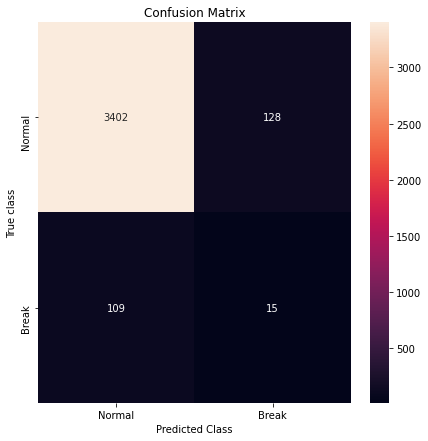

In [33]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

cm = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7,7))
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True class')
plt.show()

### ROC curve

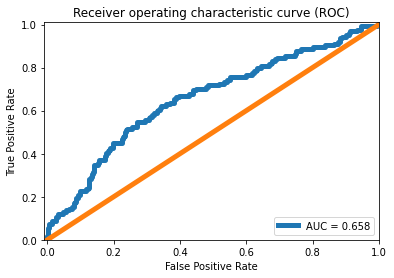

In [34]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

## Reference

- https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
- https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb